(400, 600, 3)


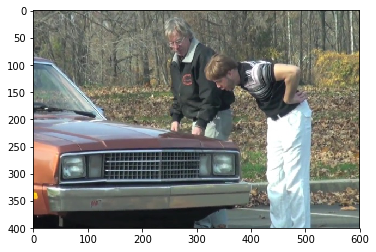

In [2]:
import sys
sys.path.insert(0, "./")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

## Let's start by importing the image as numpy array

% matplotlib inline

data_dir = "./data/"
img = mpimg.imread(data_dir + "look_at_it.jpg")
imgplot = plt.imshow(img)
print(img.shape)

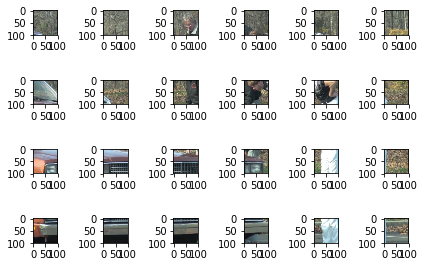

In [3]:
## Let's split the image into chunks
def split_2d_image(img):
    col_imgs = np.hsplit(img, 6)
    img_list = []
    for col in col_imgs:
        img_list.append(np.vsplit(col, 4))
    return img_list

img_list = split_2d_image(img)
fig=plt.figure(figsize=(len(img_list), len(img_list[0])))
columns = len(img_list)
rows = len(img_list[0])
count = 1

for row in range(rows):
    for col in range(columns):
        fig.add_subplot(rows, columns, count)
        plt.imshow(img_list[col][row],interpolation='nearest')
        count += 1

fig.tight_layout()
plt.show()

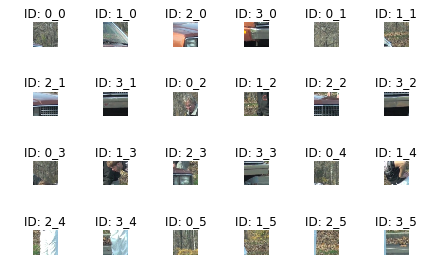

In [4]:
## Now we need to attach relevant ID's to each image. 
## This is so when we map the image pieces back together, they will know where to go.
## There are multiple ways of doing this... TODO: think of best way

## Most obvious: Two digit ID's: XY where first digit corresponds to row and second digit corresponds to column

image_map = {}

for col in range(columns):
    for row in range(rows):
        image_map[str(row) + '_' + str(col)] = img_list[col][row]

fig=plt.figure(figsize=(len(img_list), len(img_list[0])))
count = 1
for key, value in image_map.items():
    fig.add_subplot(rows, columns, count).title.set_text("ID: " + key)
    plt.imshow(value ,interpolation='nearest')
    plt.axis('off')
    count += 1

fig.tight_layout()
plt.show()

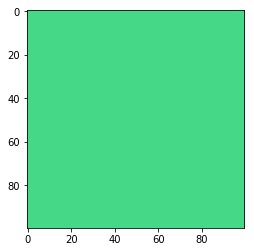

In [10]:
## Now we set a function that will be applied over each image chunk.
## We will use a very simple function for now: make everyting a random color and wait 5 seconds (to make parallel time more apparent)!
import time

def crappy_function(img):
    img.setflags(write=1)
    r = np.random.randint(1, 256)
    g = np.random.randint(1, 256)
    b = np.random.randint(1, 256)
    for y in range(len(img)):
        for x in range(len(img[0])):
            img[y][x] = [r, g, b]
            time.sleep(0.001)
    return img

## Test crappy function to make sure it works
test = crappy_function(next (iter (image_map.values())) )
plt.imshow(test)



In [18]:
## Parallel Time
## We will use Python Multiprocessing for now and switch to Scala or a Framework
## Each thread available will take on an image and do crappy function
## The thread will return the result to a list with correct size.

import threading

## result dictionary

result_list = [[None for i in range(columns)] for j in range(rows)]

## Threading lock for good practice
lock = threading.Lock()

def worker(key, img):
    result = crappy_function(img)
    print("Waiting for lock...\n")
    lock.acquire()
    print("Lock acquired\n")
    try:
        row, col = (key.split("_"))
        result_list[int(row)][int(col)] = result
    finally:
        print("Lock released\n")
        lock.release()

for key, value in image_map.items():
    t = threading.Thread(target = worker, args = (key, value))
    t.start()

Waiting for lock...
Waiting for lock...


Lock acquired

Lock released

Lock acquired

Lock released
Waiting for lock...
Waiting for lock...



Lock acquired
Lock acquired


Lock released
Lock released


Waiting for lock...

Lock acquired
Waiting for lock...


Lock released
Lock acquired


Lock released

Waiting for lock...

Waiting for lock...
Lock acquired


Lock released

Lock acquired

Lock released

Waiting for lock...
Waiting for lock...

Waiting for lock...
Waiting for lock...

Lock acquired


Lock acquired
Waiting for lock...
Waiting for lock...
Waiting for lock...
Waiting for lock...

Lock acquired
Lock acquired





Waiting for lock...
Waiting for lock...
Lock released


Lock released
Lock acquired
Lock acquired
Lock acquired
Lock acquired


Waiting for lock...

Lock released
Lock released





Lock acquired
Lock acquired

Waiting for lock...



Lock acquired
Lock released
Lock released
Lock released
Lock released


Lock acquired
Lock released
Lock released








Lock relea

In [21]:
# Brief Sanity Check
print(result_list)


[[array([[[  9, 152, 218],
        [  9, 152, 218],
        [  9, 152, 218],
        ..., 
        [  9, 152, 218],
        [  9, 152, 218],
        [  9, 152, 218]],

       [[  9, 152, 218],
        [  9, 152, 218],
        [  9, 152, 218],
        ..., 
        [  9, 152, 218],
        [  9, 152, 218],
        [  9, 152, 218]],

       [[  9, 152, 218],
        [  9, 152, 218],
        [  9, 152, 218],
        ..., 
        [  9, 152, 218],
        [  9, 152, 218],
        [  9, 152, 218]],

       ..., 
       [[  9, 152, 218],
        [  9, 152, 218],
        [  9, 152, 218],
        ..., 
        [  9, 152, 218],
        [  9, 152, 218],
        [  9, 152, 218]],

       [[  9, 152, 218],
        [  9, 152, 218],
        [  9, 152, 218],
        ..., 
        [  9, 152, 218],
        [  9, 152, 218],
        [  9, 152, 218]],

       [[  9, 152, 218],
        [  9, 152, 218],
        [  9, 152, 218],
        ..., 
        [  9, 152, 218],
        [  9, 152, 218],
        [  9, 15

In [ ]:
## Now time to merge results back into image
## This is a crappy way of doing it.. we will eventually find a better way



# Improvements / TODOs:
- There is probably a better way to merge (lots of design decisions)
- There is definitely a better parallel programming framework
- Edge Conflicts (!!!)

Look into: Memory Mapping